# IMDB movie review analysis

### Overview

## Import necessary libraries

In [1]:
import json
import pandas as pd
import re
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM , AutoModelForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/MyDrive/CA7/'

## Download punktuations and stopwords for preprocessing

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load data

In [4]:
train_data = []
test_data = []
unlabeled_data = []

def read_json(data, json_file):
    with open(json_file, 'r') as f:
        for line in f:
            line = line.strip()  # remove leading/trailing white spaces
            if line:  # ensure the line is not empty
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON: {e}")

read_json(train_data, directory + 'train_imdb.jsonl')
read_json(test_data, directory + 'test_imdb.jsonl')
read_json(unlabeled_data, directory + 'aug_imdb_unlabeled.jsonl')

In [5]:
def remove_html(text):
    text = re.sub(r"<br \/>", " ", text)
    return text


In [6]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
unlabeled_data = pd.DataFrame(unlabeled_data)

train_data['text'] = train_data['text'].apply(remove_html)
test_data['text'] = test_data['text'].apply(remove_html)
unlabeled_data['text'] = unlabeled_data['text'].apply(remove_html)


In [7]:
print(f"Unlabeled Data: {len(unlabeled_data)}")
print(f"Training Data: {len(train_data)}")
print(f"Test Data: {len(test_data)}")

Unlabeled Data: 1014
Training Data: 150
Test Data: 150


In [8]:
train_data.head(5)

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0..."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0..."


In [9]:
test_data.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664, -..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.0783471093, -0.279764235, 0.6189775467, 0...."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.0262434836, 0.0843501985, -0...."


In [10]:
unlabeled_data.head()

,text,embedding
0,there is no relation at all between fortier an...,"[-0.097577557, -0.1536363065, 0.311417222, 0.0..."
1,in the process of trying to establish the audi...,"[-0.0003366936, 0.0877778083, -0.0071643554, 0..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.3291363716, 0.079317905, 0.0..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549, -0.0..."


In [11]:
def check_list_sizes(df, column_name):
    list_lengths = df[column_name].apply(len)
    return list_lengths.nunique() == 1

# Usage
result = check_list_sizes(unlabeled_data, 'embedding')
print("All lists have the same size:", result)

All lists have the same size: True


## Preproccesing

The steps of cleaning the dataset:
- tokenize the texts
- make all the words in lowercase
- remove punctuations and stopwords
- stemmize words

In [12]:
def clean_text(text):
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"^[^-]*-\s*", "", text)
    text = re.sub(r"([^\w\s])", "", text)

    tokens = nltk.word_tokenize(text)
    remove_punct = str.maketrans('', '', string.punctuation)
    tokens = [token.lower().translate(remove_punct) for token in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    return tokens



In [13]:
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaded_text'] = test_data['text'].apply(clean_text)
unlabeled_data['cleaned_text'] = unlabeled_data['text'].apply(clean_text)

In [14]:
train_data.head()

,text,label,embedding,cleaned_text
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -...","[fairly, good, romantic, comedy, dont, think, ..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0...","[dressed, kill, one, best, thriller, ever, mad..."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0....","[seems, like, expecting, serious, treatment, c..."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0....","[left, movie, hour, return, watch, paint, dry,..."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0...","[john, candy, performance, upon, crime, possib..."


In [15]:
test_data.head()

,text,label,embedding,cleaded_text
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664, -...","[series, later, released, videodvd, full, leng..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.0783471093, -0.279764235, 0.6189775467, 0....","[hello, movie, iswellokay, kidding, awesome, b..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0...","[informed, dont, watch, show, waste, space, bo..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -...","[far, absolute, worst, movie, seen, last, 20, ..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.0262434836, 0.0843501985, -0....","[like, silent, film, little, moronic, much, wi..."


In [16]:
unlabeled_data.head()

,text,embedding,cleaned_text
0,there is no relation at all between fortier an...,"[-0.097577557, -0.1536363065, 0.311417222, 0.0...","[relation, fortier, profiler, fact, police, se..."
1,in the process of trying to establish the audi...,"[-0.0003366936, 0.0877778083, -0.0071643554, 0...","[process, trying, establish, audience, empathy..."
2,i give this movie 7 out of 10 because the vill...,"[-0.275570631, -0.3291363716, 0.079317905, 0.0...","[give, movie, 7, 10, villain, interesting, rol..."
3,this is the best sci-fi that i have seen in my...,"[0.1461943835, -0.2785910368, 0.4456491172, -0...","[fi, seen, 29, year, watching, scifi, also, be..."
4,what an appalling piece of rubbish!!! who are ...,"[0.1696606129, 0.354041934, 0.4451519549, -0.0...","[appalling, piece, rubbish, people, blubber, g..."


In [17]:
from nltk import FreqDist
import matplotlib.pyplot as plt

movie_words = '''
actor
actors
animation
animations
animes
art
audiences
bollywood
books
box office
cartoon
celluloid
characters
cinema
cinematic
cinematography
comedies
comics
computer animation
cult classic
documentary
documentary film
drama
dvd
episode
episodes
fantasy
feature
feature film
film
film director
film noir
film stock
filmmakers
filmmaking
filmography
films
filmstrip
flick
games
genre
hindi films
hollywood
hollywood blockbusters
hollywood studios
home movie
kinetoscope
media
motion picture
move picture
movie
movie buffs
movie projector
movie screen
movie theater
movie theatre
music
musical
netflix
ovas
photographic film
picture
picture show
plot
popcorn
productions
read
reshoot
romantic comedies
scene
sci fi
screen
screenplay
seasons
sequel
series
show
showbusiness
shows
silent movie
silver screen
sitcom
slow motion
sound
soundtrack
specials
stories
story
studio
studio system
talkie
talkies
telefilm
television
theater
thriller
titanic
video
video camera
videotape
'''

label_1_words = {}
label_0_words = {}

for review in train_data[train_data['label'] == 1]['cleaned_text']:
  unique_words = []
  for word in review:
    if(word not in unique_words and word not in movie_words):
      unique_words.append(word)
  for word in unique_words:
    if(word in label_1_words):
      label_1_words[word] += 1
    else:
      label_1_words[word] = 0

for review in train_data[train_data['label'] == 0]['cleaned_text']:
  unique_words = []
  for word in review:
    if(word not in unique_words and word not in movie_words):
      unique_words.append(word)
  for word in unique_words:
    if(word in label_0_words):
      label_0_words[word] += 1
    else:
      label_0_words[word] = 0

N = 30

top_1_words =  dict(sorted(label_1_words.items(), key=lambda item: item[1], reverse=True)[:N])
top_0_words =  dict(sorted(label_0_words.items(), key=lambda item: item[1], reverse=True)[:N])

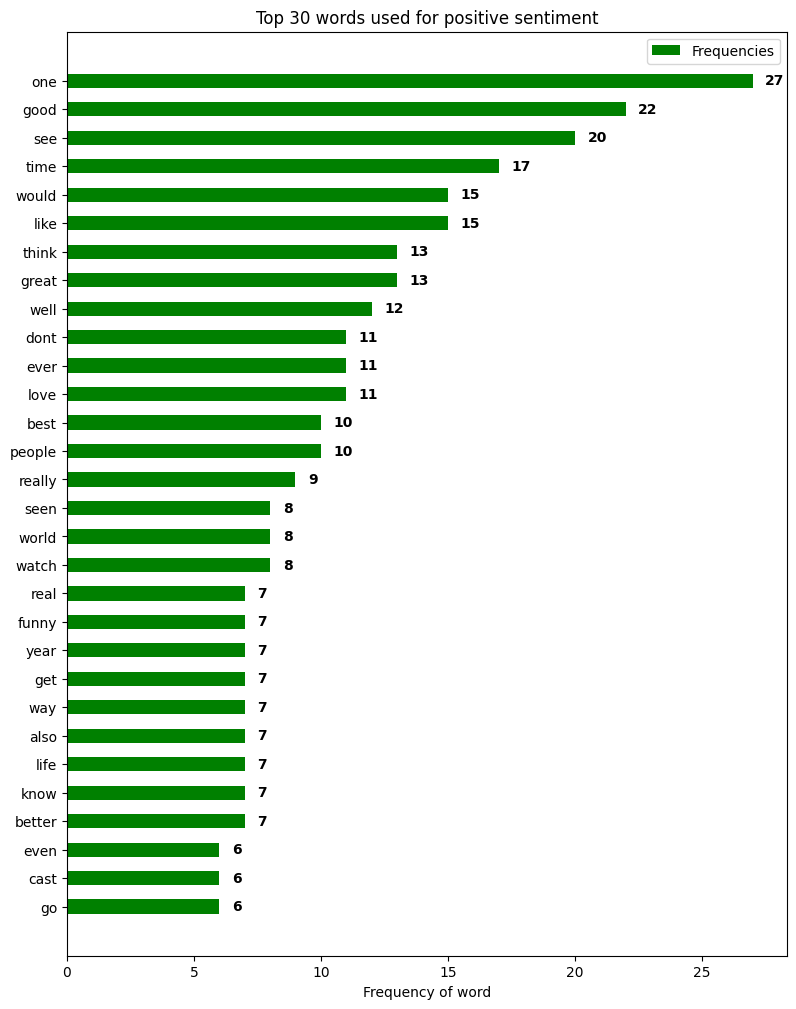

In [18]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 12))
x = np.arange(N)[::-1]
frequencies = ax.barh(x, top_1_words.values(), color='green', height=0.5, label='Frequencies')
for bar, value in zip(frequencies, top_1_words.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(top_1_words.keys())
ax.set_xlabel('Frequency of word')
ax.set_title('Top 30 words used for positive sentiment')
ax.legend()

plt.subplots_adjust(left=0.3)
plt.show()

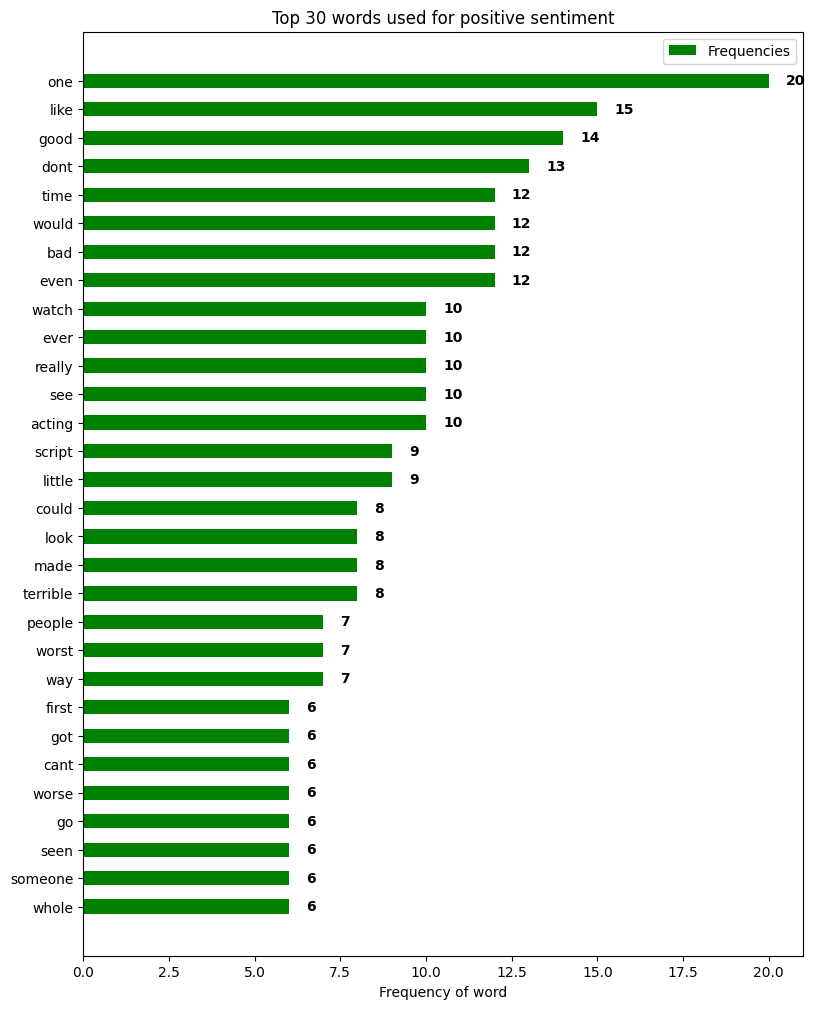

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
x = np.arange(N)[::-1]
frequencies = ax.barh(x, top_0_words.values(), color='green', height=0.5, label='Frequencies')
for bar, value in zip(frequencies, top_0_words.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(top_0_words.keys())
ax.set_xlabel('Frequency of word')
ax.set_title('Top 30 words used for positive sentiment')
ax.legend()

plt.subplots_adjust(left=0.3)
plt.show()

In [20]:
positive_reviews_size = len(train_data[train_data['label'] == 1])
negative_reviews_size = len(train_data[train_data['label'] == 0])

positive_review_avg_length = 0
negative_review_avg_length = 0

for words in train_data[train_data['label'] == 1]['cleaned_text']:
    positive_review_avg_length += len(words)

for words in train_data[train_data['label'] == 0]['cleaned_text']:
    negative_review_avg_length += len(words)

positive_review_avg_length /= positive_reviews_size
negative_review_avg_length /= negative_reviews_size

print(f"Positive reviews on average have {positive_review_avg_length} words.\nNegative review on average have {negative_review_avg_length} words.")


Positive reviews on average have 37.096385542168676 words.
Negative review on average have 40.28358208955224 words.


## Semi-supervised learning

### Using Traditional Methods (Label Propagation)

#### Label Propagation for Unlabeled Data

We'll use the `LabelSpreading` technique from `scikit-learn` to propagate labels to the unlabeled data.

In [21]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelSpreading
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop

In [22]:
X_train = np.vstack(train_data['embedding'].values)
y_train = train_data['label'].values

X_unlabeled = np.vstack(unlabeled_data['embedding'].values)
y_unlabeled = -1 * np.ones(X_unlabeled.shape[0])

X_combined = np.vstack((X_train, X_unlabeled))
y_combined = np.concatenate((y_train, y_unlabeled))

label_spread = LabelSpreading(kernel='knn', n_neighbors=3)
label_spread.fit(X_combined, y_combined)

propagated_labels = label_spread.transduction_[-len(unlabeled_data):]

propagated_labels_data = unlabeled_data.copy()
propagated_labels_data['label'] = propagated_labels

#### Combine Propagated Labels and Train Data

In [23]:
combined_data = pd.concat([train_data, propagated_labels_data], ignore_index=True)

X_train_combined = np.vstack(combined_data['embedding'].values)
y_train_combined = combined_data['label'].values

#### Build and Train a Neural Network with Early Stopping

In [24]:
def build_model():
  model = Sequential([
    Dense(2048, activation=LeakyReLU(alpha=0.01), input_shape=(X_train_combined.shape[1],), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(512, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(256, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(128, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.01), kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
  ])
  return model

def lr_scheduler(epoch, lr):
    return lr * 0.97


propagate_model = build_model()
lr_schedule = lr_scheduler
lr_callback = LearningRateScheduler(lr_schedule)



In [25]:
propagate_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

label_propagation_history = propagate_model.fit(X_train_combined, y_train_combined,
                    validation_split=0.15, epochs=100, batch_size = 4,
                    callbacks=[lr_callback, early_stopping])

Epoch 1/100
248/248 [==============================] - 13s 7ms/step - loss: 1.1019 - accuracy: 0.4732 - val_loss: 0.6963 - val_accuracy: 0.4800 - lr: 0.0029
Epoch 2/100
248/248 [==============================] - 1s 6ms/step - loss: 0.7296 - accuracy: 0.4914 - val_loss: 0.6844 - val_accuracy: 0.6286 - lr: 0.0028
Epoch 3/100
248/248 [==============================] - 1s 6ms/step - loss: 0.6915 - accuracy: 0.5713 - val_loss: 1.1651 - val_accuracy: 0.5029 - lr: 0.0027
Epoch 4/100
248/248 [==============================] - 1s 6ms/step - loss: 0.7174 - accuracy: 0.5571 - val_loss: 0.6859 - val_accuracy: 0.5486 - lr: 0.0027
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 0.6711 - accuracy: 0.5935 - val_loss: 0.6019 - val_accuracy: 0.6857 - lr: 0.0026
Epoch 6/100
248/248 [==============================] - 2s 9ms/step - loss: 0.6346 - accuracy: 0.6471 - val_loss: 0.5566 - val_accuracy: 0.7143 - lr: 0.0025
Epoch 7/100
248/248 [==============================] - 2s 9ms/s

### Evaluate model

In [26]:
import matplotlib.pyplot as plt
def plot_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'b', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

150/150 [==============================] - 1s 3ms/step - loss: 0.5146 - accuracy: 0.7400
Test Accuracy: 0.74


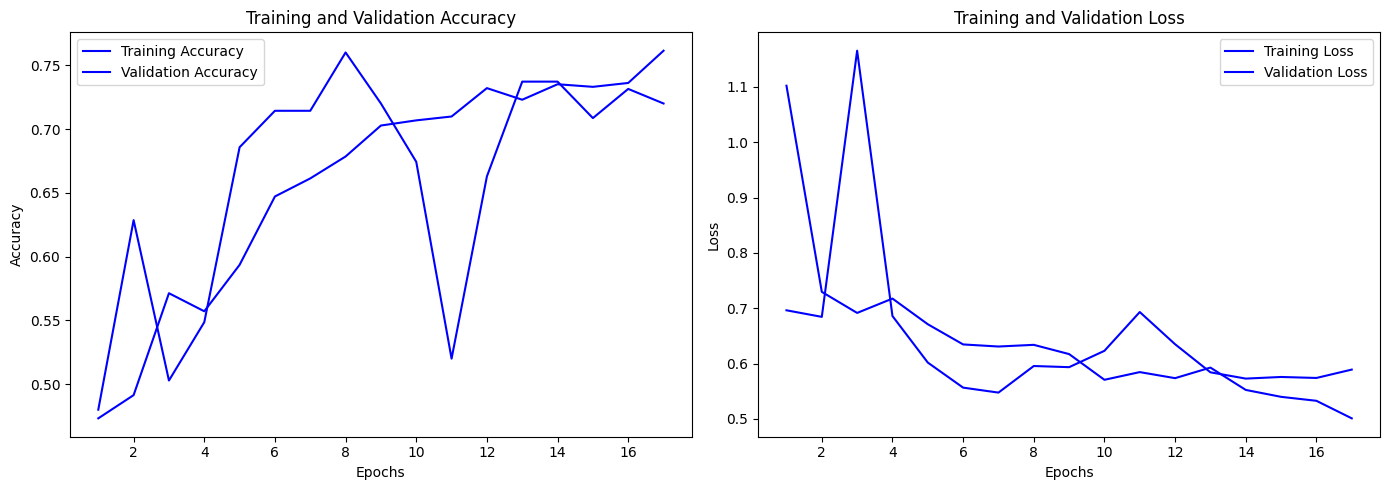

In [27]:
X_test = np.vstack(test_data['embedding'].values)
y_test = test_data['label'].values

label_propagation_test_loss, label_propagation_test_accuracy = propagate_model.evaluate(X_test, y_test, batch_size = 1)
print(f'Test Accuracy: {label_propagation_test_accuracy:.2f}')
plot_acc_loss(label_propagation_history)

### Using LLMs

In [ ]:
# !pip install accelerate transformers
# import os
# os._exit(00)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM , AutoModelForSequenceClassification
import torch

directory = '/content/drive/MyDrive/CA7/'

MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}
device = "cuda" if torch.cuda.is_available() else "cpu"

def load_model(model_args):
    print(device)

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"":device},

    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

model, tokenizer = load_model(MODEL_ARGS)


In [ ]:
PROMPT = "Classify the sentiment of the following IMDB movie comment. If the comment is positive, label it as 1. If the comment is negative, label it as 0 (just say 1 or 0. Don't explain anything)"

def label_using_phi(examples, comment, print_res=False):
  prompt = PROMPT
  prompt = prompt + 'For Example:\n'
  for index, example in examples.iterrows():
    prompt += f"Comment: {example['text']}\nOutput: {example['label']}\n"
  prompt += f'\nComment: {comment}\nAnswer:'

  input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
  output_ids = model.generate(input_ids, max_new_tokens=5)
  output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
  # print(output_text)
  return output_text[len(prompt):]

SHOWING_PATTERN = True

llm_predicted_labels = []
for index, unlabeled in unlabeled_data.iterrows():
  examples = train_data.sample(n=5)
  output = label_using_phi(examples, unlabeled['text'], SHOWING_PATTERN)
  llm_predicted_labels.append(1 if '1' in output else 0)
  if(SHOWING_PATTERN):
    SHOWING_PATTERN = False




In [39]:
llm_labeled_data = unlabeled_data.copy()
llm_labeled_data['label'] = llm_predicted_labels

llm_train_data = pd.concat([train_data,llm_labeled_data], ignore_index=True)
llm_x_data = np.vstack(llm_train_data['embedding'].values)
llm_y_data = llm_train_data['label']

In [40]:
llm_model = build_model()
llm_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

llm_history = llm_model.fit(llm_x_data, llm_y_data,
                    validation_split=0.15, epochs=100, batch_size = 4,
                    callbacks=[lr_callback, early_stopping])

Epoch 1/100
248/248 [==============================] - 12s 7ms/step - loss: 1.0233 - accuracy: 0.5238 - val_loss: 0.6185 - val_accuracy: 0.8286 - lr: 0.0029
Epoch 2/100
248/248 [==============================] - 2s 6ms/step - loss: 0.6484 - accuracy: 0.6532 - val_loss: 0.3722 - val_accuracy: 0.8286 - lr: 0.0028
Epoch 3/100
248/248 [==============================] - 2s 6ms/step - loss: 0.5858 - accuracy: 0.7219 - val_loss: 0.3788 - val_accuracy: 0.8514 - lr: 0.0027
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 0.4653 - accuracy: 0.7958 - val_loss: 0.3460 - val_accuracy: 0.8400 - lr: 0.0027
Epoch 5/100
248/248 [==============================] - 1s 6ms/step - loss: 0.4786 - accuracy: 0.8049 - val_loss: 0.3413 - val_accuracy: 0.8743 - lr: 0.0026
Epoch 6/100
248/248 [==============================] - 2s 8ms/step - loss: 0.4811 - accuracy: 0.8170 - val_loss: 0.4226 - val_accuracy: 0.9029 - lr: 0.0025
Epoch 7/100
248/248 [==============================] - 3s 11ms/

150/150 [==============================] - 2s 4ms/step - loss: 0.3566 - accuracy: 0.8200
Test Accuracy: 0.82


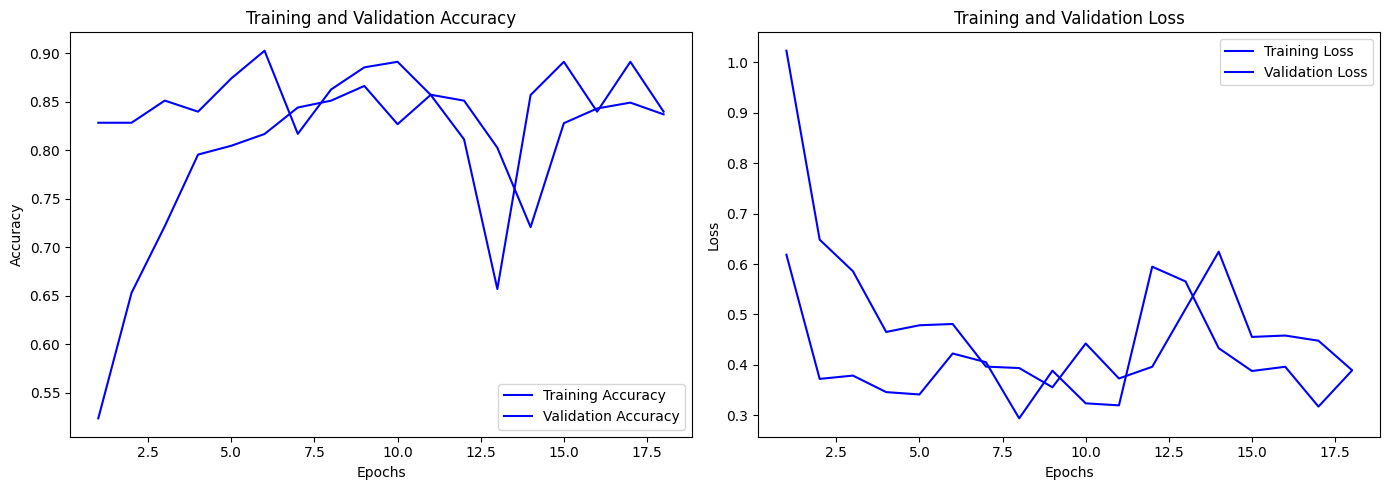

In [45]:
llm_loss, llm_acc = llm_model.evaluate(X_test, y_test, batch_size = 1)
print(f'Test Accuracy: {llm_acc:.2f}')
plot_acc_loss(llm_history)

In [28]:

model_name = "bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")

X_train = train_data['text'].values.tolist()
y_train = train_data['label'].values

X_unlabeled = unlabeled_data['text'].values.tolist()

max_length = 128
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
unlabeled_encodings = tokenizer(X_unlabeled, truncation=True, padding=True, max_length=max_length)

def classify_tokens(model, encodings):
    with torch.no_grad():
        input_ids = torch.tensor(encodings['input_ids']).to("cuda")
        attention_mask = torch.tensor(encodings['attention_mask']).to("cuda")
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    return predictions

unlabeled_predictions = classify_tokens(model, unlabeled_encodings)

y_combined[len(y_train):] = unlabeled_predictions

print("Unlabeled Data:", len(unlabeled_data))
print("Training Data:", len(train_data))
print("Test Data:", len(test_data))



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unlabeled Data: 1014
Training Data: 150
Test Data: 150


In [29]:
bert_predictions = pd.DataFrame({'label': unlabeled_predictions})

bert_labeled_data = unlabeled_data.copy()
bert_labeled_data['label'] = bert_predictions['label']

Storing labeled data results in JSON format for future use:

In [30]:
bert_labeled_data.drop(columns=['cleaned_text'], inplace=True)
bert_labeled_data = bert_labeled_data[['text', 'label', 'embedding']]


### Evaluating on test data :

In [31]:
bert_train_data = pd.concat([train_data,bert_labeled_data], ignore_index=True)
bert_x_data = np.vstack(bert_train_data['embedding'].values)
bert_y_data = bert_train_data['label']


# train_data = pd.DataFrame(combined_data)
# train_data = train_data.drop(columns=['embedding'])

In [32]:
bert_model = build_model()
bert_model.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

bert_history = bert_model.fit(bert_x_data, bert_y_data,
                    validation_split=0.15, epochs=100, batch_size = 4,
                    callbacks=[lr_callback, early_stopping])

Epoch 1/100
248/248 [==============================] - 4s 7ms/step - loss: 0.7936 - accuracy: 0.7826 - val_loss: 0.3437 - val_accuracy: 0.9314 - lr: 0.0029
Epoch 2/100
248/248 [==============================] - 2s 6ms/step - loss: 0.5715 - accuracy: 0.8311 - val_loss: 0.2680 - val_accuracy: 0.9314 - lr: 0.0028
Epoch 3/100
248/248 [==============================] - 2s 6ms/step - loss: 0.5095 - accuracy: 0.8362 - val_loss: 0.4494 - val_accuracy: 0.9314 - lr: 0.0027
Epoch 4/100
248/248 [==============================] - 2s 9ms/step - loss: 0.4923 - accuracy: 0.8392 - val_loss: 0.3861 - val_accuracy: 0.9314 - lr: 0.0027
Epoch 5/100
248/248 [==============================] - 2s 9ms/step - loss: 0.4630 - accuracy: 0.8372 - val_loss: 0.2969 - val_accuracy: 0.9314 - lr: 0.0026
Epoch 6/100
248/248 [==============================] - 2s 9ms/step - loss: 0.4602 - accuracy: 0.8392 - val_loss: 0.2753 - val_accuracy: 0.9314 - lr: 0.0025
Epoch 7/100
248/248 [==============================] - 2s 6ms/st

150/150 [==============================] - 5s 7ms/step - loss: 1.1730 - accuracy: 0.5200
Test Accuracy: 0.52


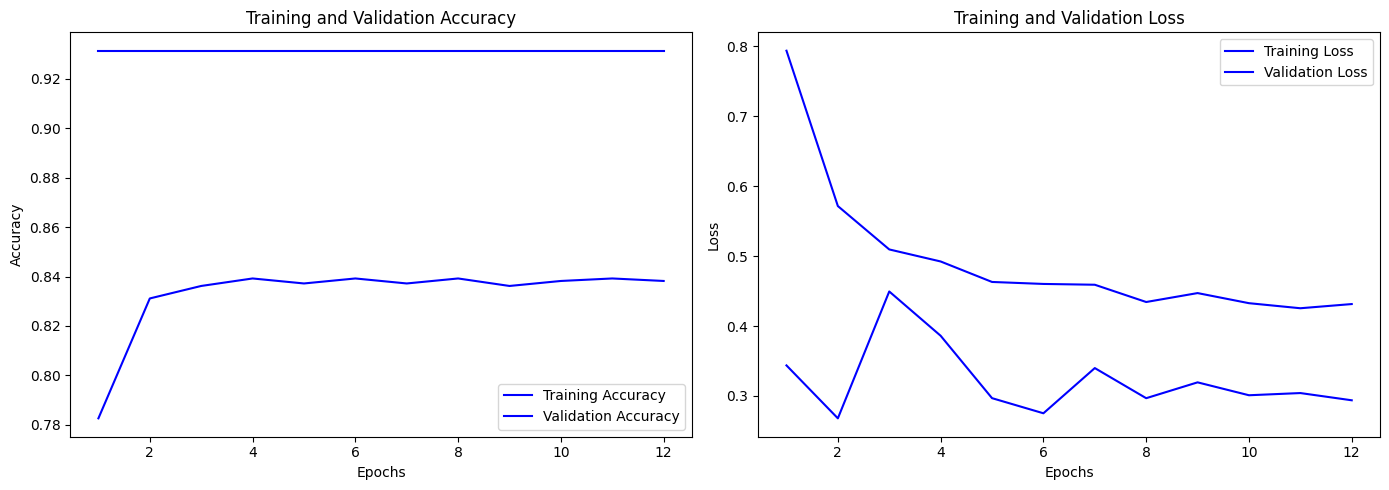

In [34]:
bert_loss, bert_acc = bert_model.evaluate(X_test, y_test, batch_size = 1)
print(f'Test Accuracy: {bert_acc:.2f}')
plot_acc_loss(bert_history)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 6e-3
EPOCHS = 5


train_dataset = CustomDataset(train_data['text'], train_data['label'], tokenizer, MAX_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_data['text'], test_data['label'], tokenizer, MAX_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
for LEARNING_RATE in [7e-3, 5e-3, 3e-3, 1e-3, 7e-4, 5e-4, 3e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]:
  for epoch in range(EPOCHS):
      model.train()
      for batch in train_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)

          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()

  model.eval()
  predictions = []
  true_labels = []

  with torch.no_grad():
      for batch in test_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['labels'].numpy()

          outputs = model(input_ids=input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          predicted_labels = logits.argmax(axis=1).cpu().numpy()

          predictions.extend(predicted_labels)
          true_labels.extend(labels)

  accuracy = accuracy_score(true_labels, predictions)
  print("Accuracy:", accuracy)

## Questions

1.

In semi-supervised learning, picking which data to label manually is super important for making our model better. We want to choose a small group of data that will teach our algorithm the most. One way to do this is by using active learning techniques like the Artificial Immune System (AIS). These methods help us find the best data points to label. We can also use density-based and cluster-based approaches to find important data in areas where there's not much information.

By doing this, we make sure the data we label are really useful and give our model a good understanding of the problem. We also need to think about how much it costs to label data and what experts in the field know. This helps us pick the right data to label and makes the most of our resources.

In the end, choosing which data to label is a big deal in semi-supervised learning. It can make a huge difference in how well our model works.

2.

We labeled all of our data using KNN with a parameter of 3 because we had a limited number of manually labeled instances (150) compared to the larger pool of unlabeled data (1014). By propagating labels to all data points, we aimed to maximize the utilization of available information and increase the coverage of labeled instances in our dataset. This helped us use the limited labeled data we had to label the larger unlabeled dataset. The trade-off between quality and quantity of labeled data is about balancing accuracy and coverage. More labeled data gives broader insights but may lack depth, while fewer labeled data points offer precision but may not cover all cases. By using label propagation, we aimed to strike a balance, ensuring both accuracy and coverage in our labeled dataset. This approach ensured that we leveraged the entirety of our dataset to train our model, potentially capturing more diverse patterns and improving its overall performance.

3.
 *  __Imbalance Problem:__ When different classes have different numbers of labeled data in the training dataset, traditional semi-supervised classifiers tend to show poor performance in low-frequency classes.

 * __Sensitivity to Iterations:__ The performance of label propagation can improve initially but may decrease after a certain number of iterations.

 * __Inability to Handle Node Features:__ Label propagation has limited ability to handle node features.

 * __Non-Unique Solutions:__ Label propagation does not produce a unique solution, but an aggregate of many solutions.

 * __Dependence on Initial Labeled Dataset:__ All these algorithms are based on the assumption that the initial labeled dataset is balanced, but this rarely appears in reality.

Large Language Models (LLMs) can potentially overcome some of these limitations:

* __Handling Imbalance:__ LLMs can be trained on a large amount of diverse data, which can help in handling class imbalance.

* __Incorporating Node Features:__ LLMs can effectively utilize node features for inferring their labels. They can capture rich semantics in the text, which is a limitation in label propagation.

* __Stable Performance:__ Unlike label propagation, the performance of LLMs does not degrade with iterations.
Unique Solutions: LLMs can provide unique solutions as they do not rely on the propagation of labels.

* __Independence from Initial Labeled Dataset:__ LLMs do not rely on the initial labeled dataset being balanced. They can learn from a large amount of diverse data, which can help in handling scenarios where the initial labeled dataset is not balanced.

4.



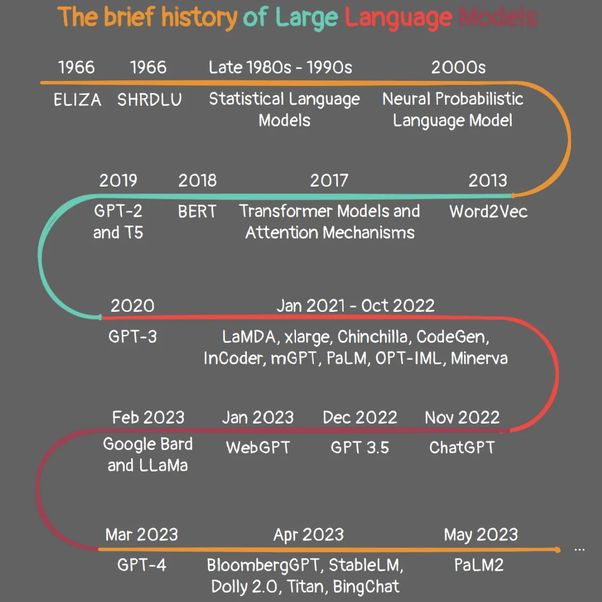

In [2]:
from IPython.display import Image
Image(filename='history.png')

The history of language modeling can be traced back to the early work on statistical language models in the field of speech recognition. One of the earliest and most influential models was the n-gram language model, which uses the probability of a word given the previous n-1 words in the sequence. These models were initially based on counting and estimating probabilities from large text corpora.

Over time, more advanced techniques were developed, such as smoothing methods to handle unseen n-grams, and the incorporation of syntactic and semantic information into the models. However, these traditional models were still limited by their reliance on fixed-length contexts and their inability to capture long-range dependencies in language.

The advent of neural network-based language models, particularly recurrent neural networks (RNNs) and later transformer models, revolutionized the field of language modeling. These models can capture long-range dependencies and learn complex patterns in language data, leading to significant improvements in performance on various NLP tasks.

Large Language Models (LLMs) are neural network-based models trained on vast amounts of text data, often using self-supervised learning techniques like masked language modeling or next-word prediction. Examples of popular LLMs include GPT (Generative Pre-trained Transformer) models by OpenAI, BERT (Bidirectional Encoder Representations from Transformers) by Google, and LaMDA (Language Model for Dialogue Applications) by Google.

LLMs work by learning representations of language that capture semantic and contextual information. During training, these models learn to predict the next word or token in a sequence based on the surrounding context. This process allows them to develop an understanding of language patterns, syntax, semantics, and even world knowledge.

### __Advantages of LLMs:__

* __Language Generation:__ LLMs excel at generating human-like text, making them useful for tasks like creative writing, content creation, and dialogue systems.

* __Language Understanding:__ LLMs can comprehend and analyze natural language, enabling applications in question answering, summarization, and text classification.
* __Transfer Learning:__ LLMs can be fine-tuned on specific tasks with relatively small amounts of task-specific data, enabling rapid development of NLP applications.
* __Multilinguality:__ Some LLMs can handle multiple languages, allowing for cross-lingual transfer and multilingual applications.


### __Limitations of LLMs:__

* __Bias and Fairness:__ LLMs can inherit biases present in the training data, potentially perpetuating harmful stereotypes or unfair representations.
Factual Inaccuracies: While LLMs can generate plausible-sounding text, they may produce factual errors or hallucinations, especially on topics not well-represented in the training data.
* __Lack of Grounding:__ LLMs may lack a deep understanding of the world and common sense reasoning, leading to inconsistencies or nonsensical outputs in certain contexts.
* __Computational Cost:__ Training and deploying LLMs require significant computational resources, making them expensive and energy-intensive.
* __Interpretability:__ LLMs are often opaque black boxes, making it challenging to interpret their decision-making process and ensure transparency and accountability.


Despite their limitations, LLMs have significantly advanced the field of NLP and opened up new possibilities for various applications. However, ongoing research is focused on addressing the challenges, such as improving factual accuracy, mitigating biases, enhancing common sense reasoning, and developing more efficient and interpretable models.

5.
## __Language Models (LLMs):__

### __Advantages:__

* __Powerful language generation capabilities:__ LLMs can generate human-like text, making them useful for tasks like creative writing, content creation, and dialogue systems.

* __Language understanding:__ LLMs can comprehend and analyze natural language, enabling applications in question answering, summarization, and text classification.

* __Transfer learning:__ LLMs can be fine-tuned on specific tasks with relatively small amounts of task-specific data, enabling rapid development of NLP applications.

* __Multilinguality:__ Some LLMs can handle multiple languages, allowing for cross-lingual transfer and multilingual applications.

### __Disadvantages:__

* __Bias and fairness issues:__ LLMs can inherit biases present in the training data, potentially perpetuating harmful stereotypes or unfair representations.

* __Factual inaccuracies and hallucinations:__ LLMs may produce factual errors or hallucinations, especially on topics not well-represented in the training data.

* __Lack of grounding and common sense reasoning:__ LLMs may lack a deep understanding of the world and common sense reasoning, leading to inconsistencies or nonsensical outputs in certain contexts.


* __Computational cost:__ Training and deploying LLMs require significant computational resources, making them expensive and energy-intensive.


* __Interpretability and transparency:__ LLMs are often opaque black boxes, making it challenging to interpret their decision-making process and ensure transparency and accountability.


## __Label Propagation:__

### __Advantages:__

* __Utilizes both labeled and unlabeled data:__ Label propagation can leverage the information from a small amount of labeled data and a larger amount of unlabeled data, making it useful when labeled data is scarce.

* __Exploits the structure of the data:__ Label propagation takes advantage of the underlying structure or relationships in the data, allowing it to propagate labels through the network or graph.

* __Iterative and adaptive:__ The label propagation process is iterative, allowing the method to adapt and refine the label assignments based on the structure and relationships in the data.


### __Disadvantages:__

* __Sensitivity to the initial label assignments:__ The performance of label propagation can be sensitive to the initial label assignments, which may introduce bias or lead to suboptimal results if the initial labels are not representative or informative.

* __Convergence issues:__ In some cases, label propagation may not converge or may converge to an unsatisfactory solution, depending on the structure of the data and the initialization.

* __Limited applicability:__ Label propagation is primarily applicable to tasks involving graph or network data, limiting its usefulness in other domains or for tasks that do not naturally fit into a graph or network structure.


